This notebook is aimed at identifying unphased regions of the priamry contigs based on short read illumina mapping data. Parts of it are really slow.


This notebook was only designed for the purpose of analyzing the Pst-104E genome. No gurantees it works in any other situtation. It will have spelling errors due to the lack of autocorrection.

### Coverage analysis script
The original idea of the script is to simply use the coverage dataframe generated by 
samtools depth -aa ${x} > ${x}.aall.cov and pull out 1x homozygous and unique coverage areas. This is fr now done with the 'bwamem.Pst79_folder5.sam.sorted.bam.aall.cov' files.
Think about use DeepTools in future when comparing mulitple mapping experiments.

#### preserved comments and ideas from the origianl version
do a groupby and the mean on this. get ride of the high coverage contigs. calcutate standard statistics. Do a rolling window on each group and convert to a gff file kind of format.
also look at the coverage on p only and calcualte coverage there in the same way this should be the diploid coverage really (kind off). 
Think about combining the two dataframes for pcontigs and do a covariation analysis on the sliding windows look for areas where there is no change for p vs ph mapping and high coverage in both cases. This should be a homozygous region.

In [2]:
%matplotlib inline

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn
import matplotlib
from Bio import SeqIO, SeqUtils
import os

In [3]:
#Define the PATH
BASE_AA_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12'
BASE_A_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'
#for now use the previous mapping that still included high coverage regions
BASE_ORIGINAL = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_E104_v1'
COV_IN_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_E104_v1/COV'
BAM_IN_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_E104_v1/SRM'
#apply analysis restricted to final assembly Pst_104E_v12
COV_OUT_PATH = os.path.join(BASE_AA_PATH, 'COV')
if not os.path.isdir(COV_OUT_PATH):
    os.mkdir(COV_OUT_PATH)

In [ ]:
input_genome = 'Pst_E104_v1'
coverage_file_suffix = 'bwamem.Pst79_folder5.sam.sorted.bam.aall.cov'
output_genome = 'Pst_104E_v12'

In [7]:
#get all the cov files with this coverage_file_suffix. Expacts to get all three p, h and ph mapping
cov_files = [os.path.join(COV_IN_PATH, x) for x in os.listdir(COV_IN_PATH) if x.endswith(coverage_file_suffix)]

In [10]:
cov_header = ["contig", "position", 'coverage']

In [11]:
ph_cov = pd.read_csv([y for y in cov_files if 'ph_ctg' in y][0], sep='\t', header=None, names=cov_header)
print('Read in following file as ph_coverage produced with samtools depth -aa feature: %s' %[y for y in cov_files if 'ph_ctg' in y][0])

In [12]:
p_cov = pd.read_csv([y for y in cov_files if 'p_ctg' in y][0], sep='\t', header=None, names=cov_header)
print('Read in following file as p_coverage produced with samtools depth -aa feature: %s' %[y for y in cov_files if 'p_ctg' in y][0])

Read in following file as p_coverage produced with samtools depth -aa feature: /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_E104_v1/COV/Pst_E104_v1_p_ctg.bwamem.Pst79_folder5.sam.sorted.bam.aall.cov


In [13]:
h_cov = pd.read_csv([y for y in cov_files if 'h_ctg' in y][0], sep='\t', header=None, names=cov_header)
print('Read in following file as h_coverage produced with samtools depth -aa feature: %s' %[y for y in cov_files if 'h_ctg' in y][0])

Read in following file as h_coverage produced with samtools depth -aa feature: /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_E104_v1/COV/Pst_E104_v1_h_ctg.bwamem.Pst79_folder5.sam.sorted.bam.aall.cov


The mean overall coverage is 132.15 and the std is 429.36 for p


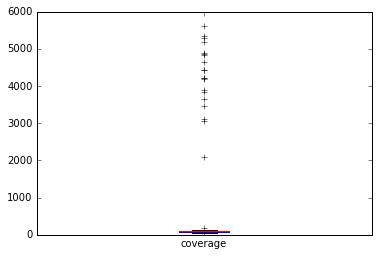

In [14]:
#summarize the mean coverage by contigs for p_contigs when mapping against p_contigs only
mean_cov_per_contig = p_cov.groupby('contig').mean()

mean_cov_per_contig['coverage'].plot.box()

overall_mean = p_cov['coverage'].mean()

overall_std = p_cov['coverage'].std()

print("The mean overall coverage is %.2f and the std is %.2f for p" % (overall_mean, overall_std))

The mean overall coverage is 71.75 and the std is 306.46 for ph mapping


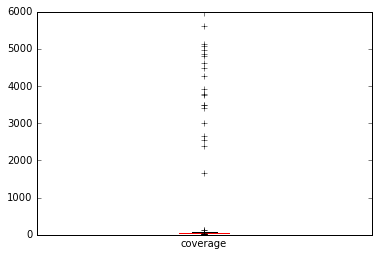

In [15]:
#summarize the mean coverage by contigs for all contigs when mapping against p and h contigs. Plot only coverage plot for p_contigs
mean_cov_per_contig_ph = ph_cov.groupby('contig').mean()
mean_cov_per_contig_ph['contig'] = mean_cov_per_contig_ph.index
mean_cov_per_contig_ph[mean_cov_per_contig_ph['contig'].str.contains('pcontig')]['coverage'].plot.box(sym ='r+')
overall_mean_ph = ph_cov['coverage'].mean()

overall_std_ph = ph_cov['coverage'].std()

print("The mean overall coverage is %.2f and the std is %.2f for ph mapping" % (overall_mean_ph, overall_std_ph))

The mean overall coverage is 114.19 and the std is 266.84 for ph mapping


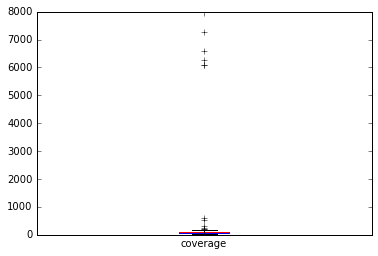

In [16]:
#summarize the mean coverage by contigs for h contigs when mapping against h contigs. Plot only coverage plot for h_contigs
mean_cov_per_contig_h = h_cov.groupby('contig').mean()
mean_cov_per_contig_h['contig'] = mean_cov_per_contig_h.index
mean_cov_per_contig_h['coverage'].plot.box(sym ='r+')

overall_mean_h = h_cov['coverage'].mean()

overall_std_h = h_cov['coverage'].std()

print("The mean overall coverage is %.2f and the std is %.2f for ph mapping" % (overall_mean_h, overall_std_h))

In [17]:
#drop all contigs that have mean coverage above 2000 as calcuated on p mapping.
pcontig_greater_2000 = mean_cov_per_contig[mean_cov_per_contig['coverage'] > 2000].index
p_cov_smaller_2000 = p_cov[~p_cov['contig'].isin(pcontig_greater_2000)]
pcontig_smaller_2000 = p_cov_smaller_2000['contig'].unique()
ph_cov_smaller_2000_p = ph_cov[ph_cov['contig'].isin(pcontig_smaller_2000)]

In [18]:
#drop all contigs that have mean coverage above 2000 as calcuated on p mapping. 
#In this case h selected on the ph contig
ph_cov['pcontig'] = ph_cov['contig'].str.replace('h','p').str[:-4] #this is a bit of a hack as the pcontigs are also
#proccessed but shorten so the next line selects only h contigs
ph_cov_smaller_2000_h = ph_cov[ph_cov['pcontig'].isin(pcontig_smaller_2000)]

In [19]:
#drop all contigs that have mean coverage above 2000 as calcuated on p mapping. Apply this to the h contigs as well
mean_cov_per_contig_h['pcontig'] = mean_cov_per_contig_h['contig'].str.replace('h','p').str[:-4]
h_cov['pcontig'] = h_cov['contig'].str.replace('h','p').str[:-4]
h_cov_smaller_2000 = h_cov[h_cov['pcontig'].isin(pcontig_smaller_2000)]

The mean overall coverage for s2000 contigs is 85.12 and the std is 22.80


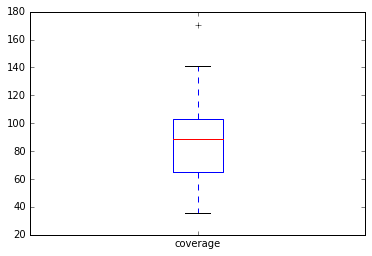

In [20]:
mean_cov_contig_s2000 = p_cov_smaller_2000.groupby(by='contig')['coverage'].mean()

mean_cov_contig_s2000.plot.box()

mean_s2000 = mean_cov_contig_s2000.mean()
std_s2000 = mean_cov_contig_s2000.std()

print("The mean overall coverage for s2000 contigs is %.2f and the std is %.2f" % (mean_s2000, std_s2000))

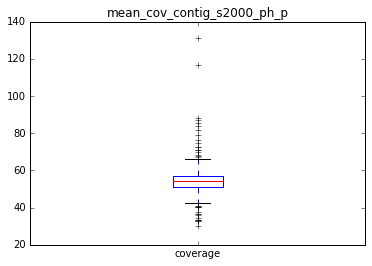

In [21]:
mean_cov_contig_s2000_ph_p = ph_cov_smaller_2000_p.groupby(by='contig')['coverage'].mean()
mean_cov_contig_s2000_ph_p.plot.box()
plt.title('mean_cov_contig_s2000_ph_p')

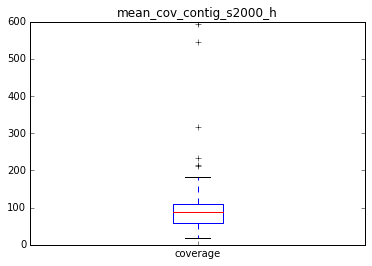

In [22]:
mean_cov_contig_s2000_h = h_cov_smaller_2000.groupby(by='contig')['coverage'].mean()
mean_cov_contig_s2000_h.plot.box()
plt.title('mean_cov_contig_s2000_h')

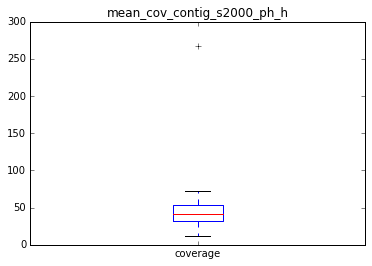

In [23]:
mean_cov_contig_s2000_ph_h = ph_cov_smaller_2000_h.groupby(by='contig')['coverage'].mean()
mean_cov_contig_s2000_ph_h.plot.box()
plt.title('mean_cov_contig_s2000_ph_h')

In [24]:
#these might be collpased repeats
mean_cov_contig_s2000_h[mean_cov_contig_s2000_h > 200]

contig
hcontig_070_009    317.736116
hcontig_073_001    233.213695
hcontig_118_002    211.449781
hcontig_118_003    213.224106
hcontig_184_001    592.538629
hcontig_193_002    544.586313
Name: coverage, dtype: float64

In [25]:
mean_cov_contig_s2000_ph_h[mean_cov_contig_s2000_ph_h >200]

contig
hcontig_070_009    267.520279
Name: coverage, dtype: float64

In [26]:
len(ph_cov_smaller_2000_p['contig'].unique())

156

In [27]:
#get the list of p contigs with haplotig [pwh] and without haplotig [pwoh]
pwh_list = pd.read_csv('/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_E104_v1/Pst_E104_v1_pwh_ctg.txt',\
sep='\t', header=None)[0].tolist()
pwoh_list = pd.read_csv('/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_E104_v1/Pst_E104_v1_pwoh_ctg.txt',\
sep='\t', header=None)[0].tolist()

In [28]:
mean_s2000_ph_p = mean_cov_contig_s2000_ph_p.mean()
std_s2000_ph_p = mean_cov_contig_s2000_ph_p.std()

print("The mean overall coverage for primary contigs with s2000 contigs is %.2f and the std is %.2f" % (mean_s2000_ph_p, std_s2000_ph_p))

The mean overall coverage for primary contigs with s2000 contigs is 55.29 and the std is 12.93


In [29]:
mean_s2000_ph_h = mean_cov_contig_s2000_ph_h.mean()
std_s2000_ph_h = mean_cov_contig_s2000_ph_h.std()

print("The mean overall coverage for haplotigs with primary contigs cov  < 2000 is %.2f and the std is %.2f" % (mean_s2000_ph_h, std_s2000_ph_h))

The mean overall coverage for haplotigs with primary contigs cov  < 2000 is 42.52 and the std is 15.77


The mean overall coverage for s2000 contigs of pwh contigs while ph mapping is 54.34 and the std is 6.38


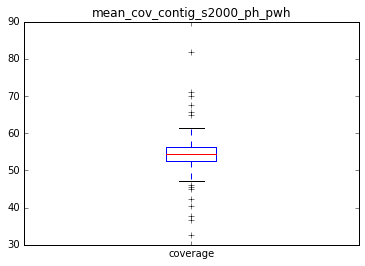

In [30]:
#mean_cov_contig_s2000_ph_pwh represents all contigs that are below 2000x coverage and are pwh contigs
mean_cov_contig_s2000_ph_pwh = mean_cov_contig_s2000_ph_p[mean_cov_contig_s2000_ph_p.index.isin(pwh_list)]
mean_cov_contig_s2000_ph_pwh.plot.box()
plt.title('mean_cov_contig_s2000_ph_pwh')
mean_s2000_ph_pwh = mean_cov_contig_s2000_ph_pwh.mean()
std_s2000_ph_pwh = mean_cov_contig_s2000_ph_pwh.std()
print("The mean overall coverage for s2000 contigs of pwh contigs while ph mapping is %.2f and the std is %.2f" % (mean_s2000_ph_pwh, std_s2000_ph_pwh))

The mean overall coverage for s2000 contigs of pwoh contigs while ph mapping is 56.92 and the std is 19.68


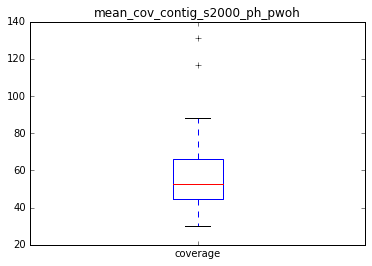

In [31]:
mean_cov_contig_s2000_ph_pwoh = mean_cov_contig_s2000_ph_p[mean_cov_contig_s2000_ph_p.index.isin(pwoh_list)]
mean_cov_contig_s2000_ph_pwoh.plot.box()
plt.title('mean_cov_contig_s2000_ph_pwoh')
mean_s2000_ph_pwoh = mean_cov_contig_s2000_ph_pwoh.mean()
std_s2000_ph_pwoh = mean_cov_contig_s2000_ph_pwoh.std()
print("The mean overall coverage for s2000 contigs of pwoh contigs while ph mapping is %.2f and the std is %.2f" % (mean_s2000_ph_pwoh, std_s2000_ph_pwoh))

In [32]:
#add h contigs as well
print("We have %i sensible pwh contigs with %i h contigs and %i sensible pwoh contigs" % (len(mean_cov_contig_s2000_ph_pwh),len(mean_cov_contig_s2000_ph_h.index), len(mean_cov_contig_s2000_ph_pwoh) ))

We have 99 sensible pwh contigs with 475 h contigs and 57 sensible pwoh contigs


In [33]:
mean_cov_contig_s2000_ph_h.index

Index(['hcontig_000_003', 'hcontig_000_005', 'hcontig_000_011',
       'hcontig_000_024', 'hcontig_000_027', 'hcontig_000_029',
       'hcontig_000_031', 'hcontig_000_036', 'hcontig_000_037',
       'hcontig_000_039',
       ...
       'hcontig_118_003', 'hcontig_129_001', 'hcontig_147_001',
       'hcontig_148_001', 'hcontig_164_001', 'hcontig_166_001',
       'hcontig_184_001', 'hcontig_189_001', 'hcontig_193_002',
       'hcontig_225_001'],
      dtype='object', name='contig', length=475)

In [34]:
mean_cov_contig_s2000_ph_pwh.index

Index(['pcontig_000', 'pcontig_001', 'pcontig_002', 'pcontig_003',
       'pcontig_004', 'pcontig_005', 'pcontig_006', 'pcontig_007',
       'pcontig_008', 'pcontig_009', 'pcontig_010', 'pcontig_011',
       'pcontig_012', 'pcontig_013', 'pcontig_014', 'pcontig_016',
       'pcontig_017', 'pcontig_018', 'pcontig_019', 'pcontig_020',
       'pcontig_021', 'pcontig_022', 'pcontig_023', 'pcontig_025',
       'pcontig_026', 'pcontig_027', 'pcontig_028', 'pcontig_029',
       'pcontig_030', 'pcontig_031', 'pcontig_032', 'pcontig_033',
       'pcontig_034', 'pcontig_035', 'pcontig_036', 'pcontig_037',
       'pcontig_039', 'pcontig_040', 'pcontig_041', 'pcontig_042',
       'pcontig_043', 'pcontig_044', 'pcontig_045', 'pcontig_046',
       'pcontig_047', 'pcontig_048', 'pcontig_049', 'pcontig_050',
       'pcontig_052', 'pcontig_054', 'pcontig_055', 'pcontig_056',
       'pcontig_057', 'pcontig_058', 'pcontig_059', 'pcontig_060',
       'pcontig_062', 'pcontig_064', 'pcontig_065', 'pcontig_0

In [35]:
mean_cov_contig_s2000_ph_p.index

Index(['pcontig_000', 'pcontig_001', 'pcontig_002', 'pcontig_003',
       'pcontig_004', 'pcontig_005', 'pcontig_006', 'pcontig_007',
       'pcontig_008', 'pcontig_009',
       ...
       'pcontig_218', 'pcontig_221', 'pcontig_223', 'pcontig_225',
       'pcontig_228', 'pcontig_230', 'pcontig_231', 'pcontig_233',
       'pcontig_235', 'pcontig_248'],
      dtype='object', name='contig', length=156)

In [36]:
#think about what thresholds to pick in the long run.
threshold_up_ph_p = mean_s2000_ph_p + 2*std_s2000_ph_p
threshold_down_ph_p = mean_s2000_ph_p - 2*std_s2000_ph_p

threshold_up = mean_s2000 + 2*std_s2000
threshold_down = mean_s2000 - 2*std_s2000

In [37]:
#potnetial fully homozygous contigs
mean_cov_contig_s2000_ph_pwoh[mean_cov_contig_s2000_ph_pwoh > threshold_up_ph_p  ]

contig
pcontig_134    131.000226
pcontig_146     85.500241
pcontig_221     87.249173
pcontig_223    116.437507
pcontig_228     83.895713
pcontig_230     87.954408
Name: coverage, dtype: float64

In [38]:
mean_cov_contig_s2000_ph_pwoh

contig
pcontig_015     51.275648
pcontig_024     46.352957
pcontig_051     57.891147
pcontig_063     58.896786
pcontig_087     54.098373
pcontig_100     57.603249
pcontig_103     52.540009
pcontig_112     54.941422
pcontig_120     48.615271
pcontig_128     74.701531
pcontig_130     43.165837
pcontig_134    131.000226
pcontig_138     53.808767
pcontig_139     76.446330
pcontig_140     68.122146
pcontig_146     85.500241
pcontig_149     48.415107
pcontig_150     50.245643
pcontig_152     49.384501
pcontig_153     62.642126
pcontig_154     48.767009
pcontig_157     44.661836
pcontig_163     44.811742
pcontig_165     44.599161
pcontig_170     51.408780
pcontig_171     52.933470
pcontig_172     65.073344
pcontig_173     40.106063
pcontig_174     72.438613
pcontig_176     40.822210
pcontig_177     59.694797
pcontig_179     78.829189
pcontig_181     40.483509
pcontig_182     71.103992
pcontig_185     36.583080
pcontig_186     33.151485
pcontig_187     33.310994
pcontig_188     53.892321
pcont

In [39]:
2*mean_s2000_ph_p - std_s2000_ph_p

97.64081332703367

In [40]:
mean_s2000 - std_s2000

62.318880782234885

In [41]:
#think about what thresholds to pick in the long run.
threshold_up_ph_p = mean_s2000_ph_p + 2*std_s2000_ph_p
threshold_down_ph_p = mean_s2000_ph_p - 2*std_s2000_ph_p

threshold_up = mean_s2000 + 2*std_s2000
threshold_down = mean_s2000 - 2*std_s2000

In [ ]:


import warnings
warnings.filterwarnings('ignore')

In [ ]:
#now write a loop that does it all for your over the whole two dataframes
bed_p_uniqe_list = []
bed_p_homo_list = []
process_p_df_dict = {}
process_ph_df_dict = {}
for contig in pcontig_smaller_2000:
    tmp_p_df = ''
    tmp_ph_df = ''
    #now subset the two dataframes
    tmp_p_df = p_cov[p_cov['contig'] == contig]
    tmp_p_df_ph = ph_cov[ph_cov['contig'] ==  contig]
    #generarte the rolling windows
    tmp_p_df['Rolling_w1000_p'] = tmp_p_df.rolling(window=1000, min_periods=1, center=True, win_type='blackmanharris')['coverage'].mean()
    tmp_p_df_ph['Rolling_w1000_ph_p'] = tmp_p_df_ph.rolling(window=1000, min_periods=1, center=True, win_type='blackmanharris')['coverage'].mean()
    tmp_p_df['Rolling_w10000_p'] = tmp_p_df.rolling(window=10000, min_periods=1, center=True, win_type='blackmanharris')['coverage'].mean()
    tmp_p_df_ph['Rolling_w10000_ph_p'] = tmp_p_df_ph.rolling(window=10000, min_periods=1,center=True, win_type='blackmanharris')['coverage'].mean()
    tmp_p_df['Rolling_w1000_ph_p'] = tmp_p_df_ph['Rolling_w1000_ph_p']
    process_p_df_dict[contig] = tmp_p_df
    process_ph_df_dict[contig] = tmp_ph_df
    #potentially p_unique DNA streatches are defined as p contig cov streatches, while doing p mapping, that are heterozygous coverage
    # coverage -> mean_s2000_ph_p
    # [Rolling_w1000_p < mean_s2000_ph_p + 2*std_s2000_ph_p]
    tmp_p_df_p_unique = tmp_p_df[tmp_p_df['Rolling_w1000_p'] < (mean_s2000_ph_p + 2*std_s2000_ph_p)]
    if len(tmp_p_df_p_unique) > 0:
        tmp_p_df_p_unique.reset_index(drop=True, inplace=True)
        #add a position +1 column by copying the position datafram 1: and adding making position+1 for the last element
        # in the dataframe equal to its own value
        tmp_p_df_p_unique['position+1']= tmp_p_df_p_unique.loc[1:, 'position'].\
        append(pd.Series(tmp_p_df_p_unique.loc[len(tmp_p_df_p_unique)-1, 'position'], index=[tmp_p_df_p_unique.index[-1]])).reset_index(drop=True)

        tmp_p_df_p_unique['position_diff+1'] = tmp_p_df_p_unique['position+1'] - tmp_p_df_p_unique['position']

        #add a position -1 column by copying the position datafram :len-2 and adding/making position-1 for the first element
        # in the dataframe equal to its own value
        position_1 = list(tmp_p_df_p_unique.loc[:len(tmp_p_df_p_unique)-2, 'position'])
        position_1.insert(0, tmp_p_df_p_unique.loc[0, 'position'])

        tmp_p_df_p_unique['position-1']= position_1

        tmp_p_df_p_unique['position_diff-1'] =  tmp_p_df_p_unique['position'] - tmp_p_df_p_unique['position-1']
        #start points of feature streatch => where previous position is unequal 1 away
        #tmp_p_df_p_unique[tmp_p_df_p_unique['position_diff-1'] != 1 ].head()

        start_pos_index = ''
        stop_pos_index = ''
        contig_name_list = ''
        p_unique_bed = ''
        #this should be good  now as it flows double check and loop around to finish this off
        start_pos_index = tmp_p_df_p_unique[tmp_p_df_p_unique['position_diff-1'] != 1 ].index
        stop_pos_index = tmp_p_df_p_unique[tmp_p_df_p_unique['position_diff+1'] != 1 ].index

        contig_name_list = [contig]*len(start_pos_index)

        start_pos = [tmp_p_df_p_unique.loc[pos, 'position'] -1 for pos in start_pos_index]
        stop_pos = [tmp_p_df_p_unique.loc[pos, 'position']  for pos in stop_pos_index]

        p_unique_bed = pd.DataFrame([contig_name_list, start_pos, stop_pos]).T
        bed_p_uniqe_list.append(p_unique_bed)
    
    #potentially p_homo DNA streatches are defined as p contig cov streatches, while doing ph mapping, that are homozygous coverage
    # coverage -> 2*mean_s2000_ph_p
    # [Rolling_w1000_p > 2*mean_s2000_ph_p - 2*std_s2000_ph_p]
    #here might be a consideration to ask for a difference in profile (covariance != 1)
    tmp_p_df_p_homo = tmp_p_df[(tmp_p_df['Rolling_w1000_ph_p'] > (2*mean_s2000_ph_p - 2*std_s2000_ph_p))]
    if len(tmp_p_df_p_homo) > 0:
        tmp_p_df_p_homo.reset_index(drop=True, inplace=True)
        #add a position +1 column by copying the position datafram 1: and adding making position+1 for the last element
        # in the dataframe equal to its own value
        tmp_p_df_p_homo['position+1']= tmp_p_df_p_homo.loc[1:, 'position'].\
        append(pd.Series(tmp_p_df_p_homo.loc[len(tmp_p_df_p_homo)-1, 'position'], index=[tmp_p_df_p_homo.index[-1]])).reset_index(drop=True)

        tmp_p_df_p_homo['position_diff+1'] = tmp_p_df_p_homo['position+1'] - tmp_p_df_p_homo['position']

        #add a position -1 column by copying the position datafram :len-2 and adding/making position-1 for the first element
        # in the dataframe equal to its own value
        position_1 = list(tmp_p_df_p_homo.loc[:len(tmp_p_df_p_homo)-2, 'position'])
        position_1.insert(0, tmp_p_df_p_homo.loc[0, 'position'])

        tmp_p_df_p_homo['position-1']= position_1

        tmp_p_df_p_homo['position_diff-1'] =  tmp_p_df_p_homo['position'] - tmp_p_df_p_homo['position-1']
        #start points of feature streatch => where previous position is unequal 1 away
        #tmp_p_df_p_homo[tmp_p_df_p_homo['position_diff-1'] != 1 ].head()

        start_pos_index = ''
        stop_pos_index = ''
        contig_name_list = ''
        p_homo_bed = ''
        #this should be good  now as it flows double check and loop around to finish this off
        start_pos_index = tmp_p_df_p_homo[tmp_p_df_p_homo['position_diff-1'] != 1 ].index
        stop_pos_index = tmp_p_df_p_homo[tmp_p_df_p_homo['position_diff+1'] != 1 ].index

        contig_name_list = [contig]*len(start_pos_index)

        start_pos = [tmp_p_df_p_homo.loc[pos, 'position'] -1 for pos in start_pos_index]
        stop_pos = [tmp_p_df_p_homo.loc[pos, 'position']  for pos in stop_pos_index]

        p_homo_bed = pd.DataFrame([contig_name_list, start_pos, stop_pos]).T
        bed_p_homo_list.append(p_homo_bed)

print('Contig %s done.' % contig)

In [50]:
len(bed_p_uniqe_list)

156

In [51]:
p_homo_bed_df = pd.concat(bed_p_homo_list).sort_values(by=[0,1])
p_unique_bed_df =  pd.concat(bed_p_uniqe_list).sort_values(by=[0,1])

In [ ]:
#p_homo_bed_df.to_csv(cov_folder+'Pst_E104_v1_ph_ctg.ph_p_homo_cov.bed', header=None, index=None, sep='\t')
#p_unique_bed_df.to_csv(cov_folder+'Pst_E104_v1_ph_ctg.p_p_het_cov.bed', header=None, index=None, sep='\t')

In [52]:
p_homo_bed_df.to_csv(os.path.join(COV_OUT_PATH, output_genome + '_ph_ctg.ph_p_homo_cov.bed'), header=None, index = None, sep ='\t')
p_unique_bed_df.to_csv(os.path.join(COV_OUT_PATH, output_genome + '-ph_ctg.p_p_het_cov.bed'), header=None, index = None, sep ='\t')

In [55]:
#also write out the proceessed dataframes with rolling and such
process_p_df = pd.concat(process_p_df_dict.values()).sort_values(by=['contig','position'])
process_ph_df = pd.concat(process_p_df_dict.values()).sort_values(by=['contig','position'])
process_p_df.to_csv(os.path.join(COV_OUT_PATH, input_genome + 'p_ctg.' +coverage_file_suffix.replace('.cov', '.processed.cov')), index = None, sep ='\t')
process_ph_df.to_csv(os.path.join(COV_OUT_PATH, input_genome + 'ph_ctg.'+coverage_file_suffix.replace('.cov', '.processed.cov')), index = None, sep ='\t')

In [69]:
process_p_df[process_p_df['Rolling_w1000_p'] <  20]

,contig,position,coverage,Rolling_w1000_p,Rolling_w10000_p,Rolling_w1000_ph_p
74442369,pcontig_000,525009,16,19.966361,88.780436,18.372209
74442370,pcontig_000,525010,16,19.922419,88.776412,18.332936
74442371,pcontig_000,525011,16,19.878734,88.772396,18.293895
74442372,pcontig_000,525012,16,19.835307,88.768387,18.255089
74442373,pcontig_000,525013,16,19.792141,88.764385,18.216517
74442374,pcontig_000,525014,16,19.749240,88.760390,18.178184
74442375,pcontig_000,525015,16,19.706607,88.756402,18.140089
74442376,pcontig_000,525016,16,19.664244,88.752422,18.102236
74442377,pcontig_000,525017,15,19.622157,88.748449,18.064625
74442378,pcontig_000,525018,15,19.580346,88.744483,18.027258
